# 2024 CITS4012 Project

# Readme

notes for marker

# 1. Dataset Processing

## Import the libraries

In [208]:
import re
import json
import nltk
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Loading the datasets

In [209]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [210]:

# Load the training data
# with open('/content/drive/MyDrive/data/train.json', 'r') as file:
with open('train.json', 'r') as file:
    data = json.load(file)
    train_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the test data
# with open('/content/drive/MyDrive/data/test.json', 'r') as file:
with open('test.json', 'r') as file:
    data = json.load(file)
    test_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the validation data
# with open('/content/drive/MyDrive/data/val.json', 'r') as file:
with open('val.json', 'r') as file:
    data = json.load(file)
    val_data = pd.DataFrame(data['data'], columns=data['columns'])

# Get the x and y lists for training, test and validation data
training_x = train_data['sentence'].tolist()
training_a = train_data['aspect'].tolist()
training_y = train_data['polarity'].tolist()
output_y = [["<BOS>"] + [y] for y in training_y]
target_y = [[y] + ["<EOS>"]for y in training_y]
test_x = test_data['sentence'].tolist()
test_a = test_data['aspect'].tolist()
test_y = test_data['polarity'].tolist()
val_x = val_data['sentence'].tolist()
val_a = val_data['aspect'].tolist()
val_y = val_data['polarity'].tolist()

## Dataset Analysis

In [211]:
# Size of datasets
print("Training data size:\t", train_data.shape)
print("Test data size:\t\t", test_data.shape)
print("Validation data size:\t", val_data.shape)

# Aspect Distribution
aspect_distribution = train_data['aspect'].value_counts()
print("\nAspect Distribution:")
print(aspect_distribution.to_string(header=False))

# Sentiment Distribution
sentiment_distribution = train_data['polarity'].value_counts()
print("\nSentiment Distribution:")
print(sentiment_distribution.to_string(header=False))

# Aspect-Sentiment Pair Distribution
aspect_polarity_pair = [(a, p) for a, p in zip(train_data['aspect'], train_data['polarity'])]
aspect_polarity_freq = pd.Series(aspect_polarity_pair).value_counts()
print("\nAspect-Sentiment Pair Distribution:")
print(aspect_polarity_freq.to_string(header=False))

Training data size:	 (7090, 3)
Test data size:		 (901, 3)
Validation data size:	 (888, 3)

Aspect Distribution:
food             2307
staff            1383
miscellaneous     954
place             694
service           631
menu              475
ambience          324
price             322

Sentiment Distribution:
neutral     3077
negative    2084
positive    1929

Aspect-Sentiment Pair Distribution:
(food, neutral)              1298
(staff, negative)             922
(food, positive)              754
(miscellaneous, neutral)      531
(place, neutral)              430
(menu, neutral)               372
(staff, positive)             332
(service, negative)           329
(food, negative)              255
(miscellaneous, positive)     227
(miscellaneous, negative)     196
(ambience, positive)          181
(service, positive)           174
(place, negative)             139
(price, neutral)              136
(staff, neutral)              129
(service, neutral)            128
(place, positive)    

## Data Preprocessing

In [212]:
# Punctuation Removal
def remove_punctuation_re(x):
    x = re.sub(r'[^\w\s]','', x)
    return x

nltk.download('punkt')

# Stopwords Removal
nltk.download('stopwords')
from nltk.corpus import stopwords as sw
from nltk.tokenize import word_tokenize
stopwords = sw.words('english')

# Stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

# Lemmatisation
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# POS Tagging
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag

# English Contractions Dictionary
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Peter\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Peter\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Peter\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Peter\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [213]:
# Function to preprocess the data
def preprocess_data(sentence_list):
    output_list = []
    for sentence in sentence_list:
        # Emoticons
        sentence = sentence.lower()                     # Case folding
        for word, new_word in contraction_dict.items(): # Deal with contractions
            sentence = sentence.replace(word, new_word)
        sentence = remove_punctuation_re(sentence)      # Remove punctuation
        tokens = word_tokenize(sentence)                # Tokenise
        # Stopwords removal
        # tokens = [word for word in tokens if word.lower() not in stopwords]
        # Lemmatisation
        # tokens = [lemmatizer.lemmatize(word) for word in tokens]
        output_list.append(tokens)
    return output_list

# Preprocess the data and get the tokenised sentence lists
train_x_token = preprocess_data(training_x)
test_x_token = preprocess_data(test_x)
val_x_token = preprocess_data(val_x)

In [214]:
# Add paddings
longest_sentence = max(train_x_token, key=len)
MAX_LENGTH = len(longest_sentence)

def add_paddings(sentence, max_seq_length):
    return sentence + ['<PAD>'] * (max_seq_length - len(sentence))

train_x_padded = [add_paddings(sentence, MAX_LENGTH) for sentence in train_x_token]

In [215]:
# Word vocabulary to index dictionary {word: index}
word_to_idx = {"<BOS>": 0, "<EOS>":1}
for sentence in train_x_token+test_x_token+val_x_token+output_y:
# for sentence in train_x_token+output_y:
    for word in sentence:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)
word_list = list(word_to_idx.keys())
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(word_to_idx)

# Aspect vocabulary to index dictionary {aspect: index}
aspect_to_idx = {
    "food": 0,
    "service": 1,
    "staff": 2,
    "price": 3,
    "ambience": 4,
    "menu": 5,
    "place": 6,
    "miscellaneous": 7
}
idx_to_aspect = {idx: aspect for aspect, idx in aspect_to_idx.items()}
num_aspects = len(aspect_to_idx)

In [216]:
# Token index lists for training data
train_x_idx = []
for sentence in train_x_token:
    sentence_idx = [word_to_idx[word] for word in sentence]
    train_x_idx.append(sentence_idx)

train_a_idx = []
for aspect in training_a:
    aspect_idx = aspect_to_idx[aspect]
    train_a_idx.append(aspect_idx)

output_y_idx = []
for sentence in output_y:
    sentence_idx = [word_to_idx[word] for word in sentence]
    output_y_idx.append(sentence_idx)

target_y_idx = []
for sentence in target_y:
    sentence_idx = [word_to_idx[word] for word in sentence]
    target_y_idx.append(sentence_idx)

# 2. Model Implementation

## Model Architecture

# LSTM

In [218]:
# Encoder
class LSTMEncoder(nn.Module):
    def __init__(self, hidden_size, embedding, num_layers=1):
        super(LSTMEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers)
        
    def forward(self, input, hidden, aspect):
        word_embedding = self.embedding(input).view(1, 1, -1)
        aspect_embedding = self.embedding(aspect).view(1, 1, -1)
        word_embedding = torch.cat((aspect_embedding, word_embedding), 0)
        output, (hidden, cell) = self.lstm(word_embedding)
        return output, hidden, cell
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

# Decoder
class LSTMDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, embedding, dropout_p=0.1, num_layers=1):
        super(LSTMDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.embedding = embedding
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers)
        self.out = nn.Linear(hidden_size*2, output_size)
    
    def cal_attention(self, hidden, encoder_hiddens):
        # Dot product attention
        attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)), dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
        concat_output = torch.cat((attn_output[0], hidden[0]), 1)
        
        # # Scaled dot product attention
        # scale = 1.0 / np.sqrt(self.hidden_size)
        # attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)) * scale, dim=-1)
        # attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
        # concat_output = torch.cat((attn_output[0], hidden[0]), 1)
            
        # # Cosine similarity attention
        # dot_product = torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0))
        # hidden_norm = torch.norm(hidden, dim=-1).unsqueeze(1)
        # encoder_norm = torch.norm(encoder_hiddens, dim=-1).unsqueeze(0)
        # norm_product = torch.bmm(hidden_norm, encoder_norm)
        # cosine_similarity = dot_product / norm_product
        # attn_weights = F.softmax(cosine_similarity, dim=-1)
        # attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
        # concat_output = torch.cat((attn_output[0], hidden[0]), 1)
        return concat_output
    
    def forward(self, input, hidden, cell, encoder_hiddens):
        word_embedding = self.embedding(input).view(1, 1, -1)
        word_embedding = self.dropout(word_embedding)
        _, (hidden, cell) = self.lstm(word_embedding, (hidden, cell))
        concat_output = self.cal_attention(hidden, encoder_hiddens)
        output = F.log_softmax(self.out(concat_output), dim=1)
        return output, hidden, cell
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [219]:
num_epochs = 10000
display_interval = 50
learning_rate = 0.01
hidden_size = 50
embedding = nn.Embedding(vocab_size, hidden_size)

encoder = LSTMEncoder(hidden_size, embedding, num_layers=1)
decoder = LSTMDecoder(hidden_size, vocab_size, embedding, dropout_p=0.1, num_layers=1)

encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()
plot_losses = []
plot_avg_losses = []
total_loss = 0

for epoch in range(1, num_epochs+1):
    random_idx = random.choice(range(len(train_data)))
    x_index = [[idx] for idx in train_x_idx[random_idx]]
    y_index = [[idx] for idx in target_y_idx[random_idx]]
    a_index = train_a_idx[random_idx]
    
    x_tensor = torch.LongTensor(x_index)
    y_tensor = torch.LongTensor(y_index)
    a_tensor = torch.LongTensor([a_index])
    x_length = x_tensor.size(0)
    y_length = y_tensor.size(0)
    
    loss = 0
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # Feed the x_tensor (sentence) into the encoder
    encoder_hiddens = torch.zeros(MAX_LENGTH, encoder.hidden_size) # For attention mechanism
    encoder_hidden = encoder.init_hidden() # Hidden state for encoder
    for i in range(x_length):
        encoder_output, encoder_hidden, encoder_cell = encoder(x_tensor[i], encoder_hidden, a_tensor)
        encoder_hiddens[i] = encoder_hidden[0, 0]

    decoder_input = torch.tensor([[word_to_idx["<BOS>"]]]) 
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    # Feed the y_tensor (polarity) into the decoder with teacher forcing
    for i in range(y_length):
        decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell, encoder_hiddens)
        loss += criterion(decoder_output, y_tensor[i])
        decoder_input = y_tensor[i]

    # Backpropagation
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    loss = loss.item() / y_length
    total_loss += loss
    plot_losses.append(loss)
    
    if (epoch+1) % display_interval == 0:
        avg_loss = total_loss / display_interval
        plot_avg_losses.append(avg_loss)
        total_loss = 0
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    

Epoch [50/10000], Loss: 8.4313
Epoch [100/10000], Loss: 7.7142
Epoch [150/10000], Loss: 6.0258
Epoch [200/10000], Loss: 3.5766
Epoch [250/10000], Loss: 2.4139
Epoch [300/10000], Loss: 1.3864
Epoch [350/10000], Loss: 0.9233
Epoch [400/10000], Loss: 0.7155
Epoch [450/10000], Loss: 0.6147
Epoch [500/10000], Loss: 0.6007
Epoch [550/10000], Loss: 0.6252
Epoch [600/10000], Loss: 0.6059
Epoch [650/10000], Loss: 0.6071
Epoch [700/10000], Loss: 0.5912
Epoch [750/10000], Loss: 0.5615
Epoch [800/10000], Loss: 0.5915
Epoch [850/10000], Loss: 0.5443
Epoch [900/10000], Loss: 0.5411
Epoch [950/10000], Loss: 0.5536
Epoch [1000/10000], Loss: 0.5404
Epoch [1050/10000], Loss: 0.5729
Epoch [1100/10000], Loss: 0.5564
Epoch [1150/10000], Loss: 0.5322
Epoch [1200/10000], Loss: 0.5275
Epoch [1250/10000], Loss: 0.5703
Epoch [1300/10000], Loss: 0.5526
Epoch [1350/10000], Loss: 0.5225
Epoch [1400/10000], Loss: 0.5345
Epoch [1450/10000], Loss: 0.5644
Epoch [1500/10000], Loss: 0.5345
Epoch [1550/10000], Loss: 0.53

# GRU

In [246]:
# Encoder
class GRUEncoder(nn.Module):
    def __init__(self, hidden_size, embedding):
        super(GRUEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input, hidden, aspect):
        word_embedding = self.embedding(input).view(1, 1, -1)
        aspect_embedding = self.embedding(aspect).view(1, 1, -1)
        word_embedding = torch.cat((word_embedding, aspect_embedding), 0)
        output, hidden = self.gru(word_embedding, hidden)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

# Decoder
class GRUDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, embedding, dropout_p=0.1):
        super(GRUDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.embedding = embedding
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size*2, self.output_size)
    
    def cal_attention(self, hidden, encoder_hiddens):
        attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)), dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
        concat_output = torch.cat((attn_output[0], hidden[0]), 1)
        return concat_output
    
    def forward(self, input, hidden, encoder_hiddens):
        word_embedding = self.embedding(input).view(1, 1, -1)
        word_embedding = self.dropout(word_embedding)
        
        # NO ASPECT
        _, hidden = self.gru(word_embedding, hidden)
        
        # YES ASPECT
        # aspect_embedding = self.embedding(aspect).view(1, 1, -1)
        # x_len = torch.sum(input != 0, dim=-1)
        # x_len_max = torch.max(x_len)
        # aspect_len = torch.sum(aspect != 0, dim=-1).float()
        # aspect_pool = torch.div(torch.sum(aspect, dim=1), aspect_len.unsqueeze(1))
        # aspect = aspect_pool.unsqueeze(1).expand(-1, x_len_max, -1)
        # embedded = torch.cat((aspect_embedding, word_embedding), 0)
        # _, hidden = self.gru(embedded, hidden)
        
        concat_output = self.cal_attention(hidden, encoder_hiddens)
        output = F.log_softmax(self.out(concat_output), dim=1)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

## Model Training

In [247]:

num_epochs = 10000
display_interval = 500
learning_rate = 0.01
hidden_size = 50
embedding = nn.Embedding(vocab_size, hidden_size)

encoder = GRUEncoder(hidden_size, embedding)
decoder = GRUDecoder(hidden_size, vocab_size, embedding, dropout_p=0.1) # vocab_size?

encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()
plot_losses = []
plot_avg_losses = []
total_loss = 0

for epoch in range(1, num_epochs+1):
    random_idx = random.choice(range(len(train_data)))
    x_index = [[idx] for idx in train_x_idx[random_idx]]
    y_index = [[idx] for idx in target_y_idx[random_idx]]
    a_index = train_a_idx[random_idx]
    
    x_tensor = torch.LongTensor(x_index)
    y_tensor = torch.LongTensor(y_index)
    a_tensor = torch.LongTensor([a_index])
    x_length = x_tensor.size(0)
    y_length = y_tensor.size(0)
    
    loss = 0
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # Feed the x_tensor (sentence) into the encoder
    encoder_hiddens = torch.zeros(MAX_LENGTH, encoder.hidden_size) # For attention mechanism
    encoder_hidden = encoder.init_hidden() # Hidden state for encoder
    for i in range(x_length):
        encoder_output, encoder_hidden = encoder(x_tensor[i], encoder_hidden, a_tensor)
        encoder_hiddens[i] = encoder_hidden[0, 0]

    decoder_input = torch.tensor([[word_to_idx["<BOS>"]]]) 
    decoder_hidden = encoder_hidden

    # Feed the y_tensor (polarity) into the decoder with teacher forcing
    for i in range(y_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_hiddens)
        loss += criterion(decoder_output, y_tensor[i])
        decoder_input = y_tensor[i]

    # Backpropagation
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    loss = loss.item() / y_length
    total_loss += loss
    plot_losses.append(loss)
    
    if (epoch+1) % display_interval == 0:
        avg_loss = total_loss / display_interval
        plot_avg_losses.append(avg_loss)
        total_loss = 0
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    

Epoch [500/10000], Loss: 1.5268
Epoch [1000/10000], Loss: 0.5025
Epoch [1500/10000], Loss: 0.4915
Epoch [2000/10000], Loss: 0.5076
Epoch [2500/10000], Loss: 0.4920
Epoch [3000/10000], Loss: 0.4744
Epoch [3500/10000], Loss: 0.5072
Epoch [4000/10000], Loss: 0.5164
Epoch [4500/10000], Loss: 0.4897
Epoch [5000/10000], Loss: 0.5069
Epoch [5500/10000], Loss: 0.4927
Epoch [6000/10000], Loss: 0.4692
Epoch [6500/10000], Loss: 0.4728
Epoch [7000/10000], Loss: 0.4588
Epoch [7500/10000], Loss: 0.4748
Epoch [8000/10000], Loss: 0.4754
Epoch [8500/10000], Loss: 0.4846
Epoch [9000/10000], Loss: 0.4924
Epoch [9500/10000], Loss: 0.4834
Epoch [10000/10000], Loss: 0.4634


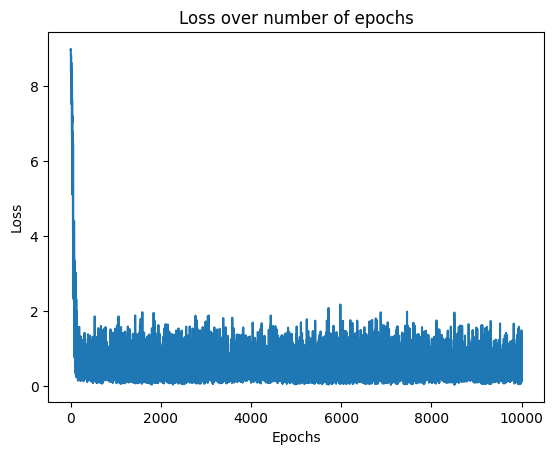

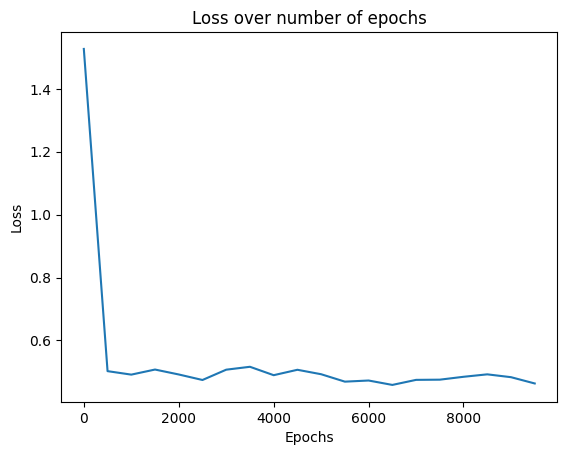

In [248]:
# Plot loss over number of epochs
plt.plot(range(1, num_epochs+1), plot_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over number of epochs')
plt.show()

plt.plot(range(1, num_epochs+1, display_interval), plot_avg_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over number of epochs')
plt.show()

## Model 2

## Model 3

# 3. Testing and Evaluation

## Model Evaluation

In [222]:
# LSTM evaluate
def LSTMevaluate(encoder, decoder, sentence, aspect, max_length=MAX_LENGTH):
    with torch.no_grad():
        input = preprocess_data([sentence])[0]
        input_idx = [word_to_idx[word] for word in input]
        input_tensor = torch.LongTensor([[ind] for ind in input_idx])
        
        input_length = input_tensor.size(0)
        encoder_hidden = encoder.init_hidden()
        
        asp_idx = aspect_to_idx[aspect]
        asp_tensor = torch.LongTensor([[asp_idx]])

        encoder_hiddens = torch.zeros(max_length, encoder.hidden_size)

        for ei in range(input_length):
            _, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, asp_tensor)
            encoder_hiddens[ei] += encoder_hidden[0, 0]

        decoder_input = torch.LongTensor([[word_to_idx["<BOS>"]]]) 
        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell
        decoded_words = []
        
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell, encoder_hiddens)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == word_to_idx["<EOS>"]:
                decoded_words.append("<EOS>")
                break
            else:
                decoded_words.append(word_list[topi.item()])
            decoder_input = topi.squeeze().detach()

        return decoded_words

In [223]:
# Test the LSTM model using the val data
for i in range(len(val_x[:10])):
    polarity = LSTMevaluate(encoder, decoder, val_x[i], val_a[i])[0]
    print(f"Predicted polarity: {polarity}, Actual polarity: {val_y[i]}")

Predicted polarity: negative, Actual polarity: neutral
Predicted polarity: neutral, Actual polarity: positive
Predicted polarity: negative, Actual polarity: negative
Predicted polarity: neutral, Actual polarity: neutral
Predicted polarity: negative, Actual polarity: negative
Predicted polarity: neutral, Actual polarity: neutral
Predicted polarity: negative, Actual polarity: neutral
Predicted polarity: neutral, Actual polarity: negative
Predicted polarity: neutral, Actual polarity: positive
Predicted polarity: neutral, Actual polarity: neutral


In [224]:
# Test the LSTM model using the test data
for i in range(len(test_x[:10])):
    polarity = LSTMevaluate(encoder, decoder, test_x[i], test_a[i])[0]
    print(f"Predicted polarity: {polarity}, Actual polarity: {test_y[i]}")

Predicted polarity: neutral, Actual polarity: neutral
Predicted polarity: neutral, Actual polarity: negative
Predicted polarity: neutral, Actual polarity: positive
Predicted polarity: negative, Actual polarity: negative
Predicted polarity: negative, Actual polarity: negative
Predicted polarity: neutral, Actual polarity: neutral
Predicted polarity: neutral, Actual polarity: negative
Predicted polarity: neutral, Actual polarity: neutral
Predicted polarity: neutral, Actual polarity: neutral
Predicted polarity: neutral, Actual polarity: negative


In [225]:
# Measure accuracy of LSTM model on test set
correct = 0
for i in range(len(val_x)):
    polarity = LSTMevaluate(encoder, decoder, val_x[i], val_a[i])[0]
    if polarity == val_y[i]:
        correct += 1
accuracy = correct / len(val_x_token)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5827


In [226]:
# Measure accuracy of LSTM model on test set
correct = 0
for i in range(len(test_x)):
    polarity = LSTMevaluate(encoder, decoder, test_x[i], test_a[i])[0]
    if polarity == test_y[i]:
        correct += 1
accuracy = correct / len(test_x_token)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5860


In [249]:
# GRU evaluate
def GRUevaluate(encoder, decoder, sentence, aspect, max_length=MAX_LENGTH):
    with torch.no_grad():
        input = preprocess_data([sentence])[0]
        input_idx = [word_to_idx[word] for word in input]
        input_tensor = torch.LongTensor([[ind] for ind in input_idx])
        
        input_length = input_tensor.size(0)
        encoder_hidden = encoder.init_hidden()
        
        asp_idx = aspect_to_idx[aspect]
        asp_tensor = torch.LongTensor([[asp_idx]])

        encoder_hiddens = torch.zeros(max_length, encoder.hidden_size)

        for ei in range(input_length):
            _, encoder_hidden = encoder(input_tensor[ei], encoder_hidden, asp_tensor)
            encoder_hiddens[ei] += encoder_hidden[0, 0]

        decoder_input = torch.LongTensor([[word_to_idx["<BOS>"]]]) 
        decoder_hidden = encoder_hidden
        decoded_words = []
        
        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_hiddens)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == word_to_idx["<EOS>"]:
                decoded_words.append("<EOS>")
                break
            else:
                decoded_words.append(word_list[topi.item()])
            decoder_input = topi.squeeze().detach()

        return decoded_words

In [250]:
# Test the GRU model using the test data
for i in range(len(val_x[:10])):
    polarity = GRUevaluate(encoder, decoder, val_x[i], val_a[i])[0]
    print(f"Predicted polarity: {polarity}, Actual polarity: {val_y[i]}")

Predicted polarity: neutral, Actual polarity: neutral
Predicted polarity: positive, Actual polarity: positive
Predicted polarity: negative, Actual polarity: negative
Predicted polarity: neutral, Actual polarity: neutral
Predicted polarity: negative, Actual polarity: negative
Predicted polarity: neutral, Actual polarity: neutral
Predicted polarity: negative, Actual polarity: neutral
Predicted polarity: neutral, Actual polarity: negative
Predicted polarity: neutral, Actual polarity: positive
Predicted polarity: neutral, Actual polarity: neutral


In [251]:
# Test the GRU model using the test data
for i in range(len(test_x[:10])):
    polarity = GRUevaluate(encoder, decoder, test_x[i], test_a[i])[0]
    print(f"Predicted polarity: {polarity}, Actual polarity: {test_y[i]}")

Predicted polarity: neutral, Actual polarity: neutral
Predicted polarity: neutral, Actual polarity: negative
Predicted polarity: positive, Actual polarity: positive
Predicted polarity: negative, Actual polarity: negative
Predicted polarity: negative, Actual polarity: negative
Predicted polarity: neutral, Actual polarity: neutral
Predicted polarity: neutral, Actual polarity: negative
Predicted polarity: neutral, Actual polarity: neutral
Predicted polarity: neutral, Actual polarity: neutral
Predicted polarity: neutral, Actual polarity: negative


In [253]:
# Measure accuracy of GRU model on test set
correct = 0
for i in range(len(val_x)):
    polarity = GRUevaluate(encoder, decoder, val_x[i], val_a[i])[0]
    if polarity == val_y[i]:
        correct += 1
accuracy = correct / len(val_x_token)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6194


In [255]:
# Measure accuracy of GRU model on test set
correct = 0
for i in range(len(test_x)):
    polarity = GRUevaluate(encoder, decoder, test_x[i], test_a[i])[0]
    if polarity == test_y[i]:
        correct += 1
accuracy = correct / len(test_x_token)
print(f"Accuracy: {accuracy:.4f}")

# old acc (before aspect) = 0.4451
# new acc (with aspect) = 0.6182

Accuracy: 0.6182
